In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix , classification_report 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


C:\Users\Ahmed\AppData\Local\Temp\ipykernel_1972\677698274.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

In [3]:
#read the train and test data 
train_path= r"D:\AMIT Course\Graduation Project\emotion detection\emotions data\train"
test_path= r"D:\AMIT Course\Graduation Project\emotion detection\emotions data\test"


In [4]:
#declare preprocess function that wil be used
preprocess_function = tf.keras.applications.densenet.preprocess_input

In [5]:
#loading the data 
train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.05,
                                   rescale = 1./255,
                                   validation_split = 0.2,
                                   preprocessing_function=preprocess_function
                                  )
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2,
                                  preprocessing_function=preprocess_function
                                  )

#reshape the inputs and prepare features and labels
train_generator = train_datagen.flow_from_directory(directory = train_path,
                                                    target_size = (48 ,48),
                                                    batch_size = 64,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    subset = "training",
                                                    seed = 12
                                                   )

validation_generator = test_datagen.flow_from_directory(directory = train_path,
                                                         target_size = (48 ,48),
                                                         batch_size = 64,
                                                         shuffle  = True , 
                                                         color_mode = "rgb",
                                                         class_mode = "categorical",
                                                         subset = "validation",
                                                         seed = 12
                                                        )

test_generator = test_datagen.flow_from_directory(directory = test_path,
                                                   target_size = (48 ,48),
                                                    batch_size = 64,
                                                    shuffle  = False , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [21]:
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]

Using Densenet network

We will have 2 parts 

In [7]:
#feature extraction part
def feature_extract(inputs):
    feature_extractor = tf.keras.applications.DenseNet169(input_shape=(48,48, 3),
                                               include_top=False,
                                               #using pre_trained weights of imagenet
                                               weights="imagenet")(inputs)
    
    return feature_extractor

In [8]:
#classification part
def classify(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(256, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(1024, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5) (x)
    x = tf.keras.layers.Dense(7, activation="softmax", name="classification")(x)
    
    return x

In [9]:
def DL_model(inputs):
    densenet_feature_extractor = feature_extract(inputs)
    classification_output = classify(densenet_feature_extractor)
    
    return classification_output

In [10]:
inputs = tf.keras.layers.Input(shape=(48 ,48,3))
classification_output = DL_model(inputs) 
model = tf.keras.Model(inputs=inputs, outputs = classification_output)

model.compile(optimizer=tf.keras.optimizers.SGD(0.01), loss='categorical_crossentropy',metrics = ['accuracy'])

model.layers[1].trainable = False


In [11]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet169 (Functional)        │ (None, 1, 1, 1664)     │    12,642,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1664)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       426,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification (Dense)          │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,860,679 (52.87 MB)

 Trainable params: 1,217,799 (4.65 MB)

 Non-trainable params: 12,642,880 (48.23 MB)

In [13]:
history = model.fit(x = train_generator,epochs = 20 ,validation_data = validation_generator )

print(history)

Epoch 1/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 182s 502ms/step - accuracy: 0.2296 - loss: 16.2097 - val_accuracy: 0.2513 - val_loss: 14.7106
Epoch 2/20
305/359 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.2375 - loss: 14.3371

KeyboardInterrupt: 

results are bad so we will try some approaches

In [14]:
#use early stopping to improve the results
earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                         patience=3,
                                                         verbose= 1 ,
                                                         restore_best_weights=True
                                                        )


In [ ]:
#history = model.fit(x = train_generator,epochs = 20 ,validation_data = validation_generator ,callbacks= [earlyStoppingCallback])

Epoch 1/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 35s 98ms/step - accuracy: 0.2483 - loss: 12.5875 - val_accuracy: 0.2513 - val_loss: 11.4705
Epoch 2/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 35s 98ms/step - accuracy: 0.2475 - loss: 11.1432 - val_accuracy: 0.2513 - val_loss: 10.1815
Epoch 3/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 35s 97ms/step - accuracy: 0.2453 - loss: 9.8959 - val_accuracy: 0.2513 - val_loss: 9.0630
Epoch 4/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 35s 97ms/step - accuracy: 0.2492 - loss: 8.8148 - val_accuracy: 0.2513 - val_loss: 8.0896
Epoch 5/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 35s 97ms/step - accuracy: 0.2532 - loss: 7.8758 - val_accuracy: 0.2513 - val_loss: 7.2494
Epoch 6/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 35s 97ms/step - accuracy: 0.2546 - loss: 7.0603 - val_accuracy: 0.2513 - val_loss: 6.5226
Epoch 7/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 35s 96ms/step - accuracy: 0.2512 - loss: 6.3654 - val_accuracy: 0.2513 - val_loss: 5.8927
Epoch 8/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 35s 98ms/step - accuracy: 0.2540 - loss: 5.749

In [18]:
#reduce the learining rate and change the optimizer

#unfreeze the learnable layers
model.layers[1].trainable = True

model.compile(optimizer=tf.keras.optimizers.RMSprop(0.001), loss='categorical_crossentropy', metrics = ['accuracy'])

history2 = model.fit(x = train_generator,epochs = 20 ,validation_data = validation_generator)


Epoch 1/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 177s 379ms/step - accuracy: 0.6628 - loss: 1.0419 - val_accuracy: 0.6130 - val_loss: 1.1634
Epoch 2/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 130s 362ms/step - accuracy: 0.6717 - loss: 0.9905 - val_accuracy: 0.6171 - val_loss: 1.2586
Epoch 3/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 129s 358ms/step - accuracy: 0.6695 - loss: 0.9862 - val_accuracy: 0.6098 - val_loss: 1.2377
Epoch 4/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 131s 364ms/step - accuracy: 0.6722 - loss: 0.9974 - val_accuracy: 0.6227 - val_loss: 1.2077
Epoch 5/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 128s 357ms/step - accuracy: 0.6842 - loss: 0.9758 - val_accuracy: 0.6150 - val_loss: 1.2461
Epoch 6/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 128s 357ms/step - accuracy: 0.6819 - loss: 0.9703 - val_accuracy: 0.6077 - val_loss: 1.1830
Epoch 7/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 128s 357ms/step - accuracy: 0.6872 - loss: 0.9568 - val_accuracy: 0.6049 - val_loss: 1.2493
Epoch 8/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 128s 356ms/step - accuracy: 0.6868 -

In [21]:
history2 = pd.DataFrame(history2.history)

In [22]:
#model evaluation 
model.evaluate(test_generator)
predictions = model.predict(test_generator)
y_preds = np.argmax(predictions , axis = 1 )
y_test = np.array(test_generator.labels)

  1/113 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 0.6562 - loss: 1.5038

C:\Users\Ahmed\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


113/113 ━━━━━━━━━━━━━━━━━━━━ 30s 267ms/step - accuracy: 0.5838 - loss: 1.3517
113/113 ━━━━━━━━━━━━━━━━━━━━ 15s 105ms/step


In [30]:
print("ROC-AUC Score  = " ,roc_auc_score(to_categorical(y_test) , predictions))

ROC-AUC Score  =  0.8785859118410959


In [24]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.51      0.58      0.54       958
           1       0.00      0.00      0.00       111
           2       0.45      0.37      0.41      1024
           3       0.85      0.85      0.85      1774
           4       0.52      0.72      0.60      1233
           5       0.53      0.44      0.48      1247
           6       0.78      0.71      0.74       831

    accuracy                           0.62      7178
   macro avg       0.52      0.52      0.52      7178
weighted avg       0.62      0.62      0.61      7178



C:\Users\Ahmed\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Ahmed\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Ahmed\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

In [27]:
model.save('emotion_detection_model2.keras')

ROC AUC score: 0.900992342667112


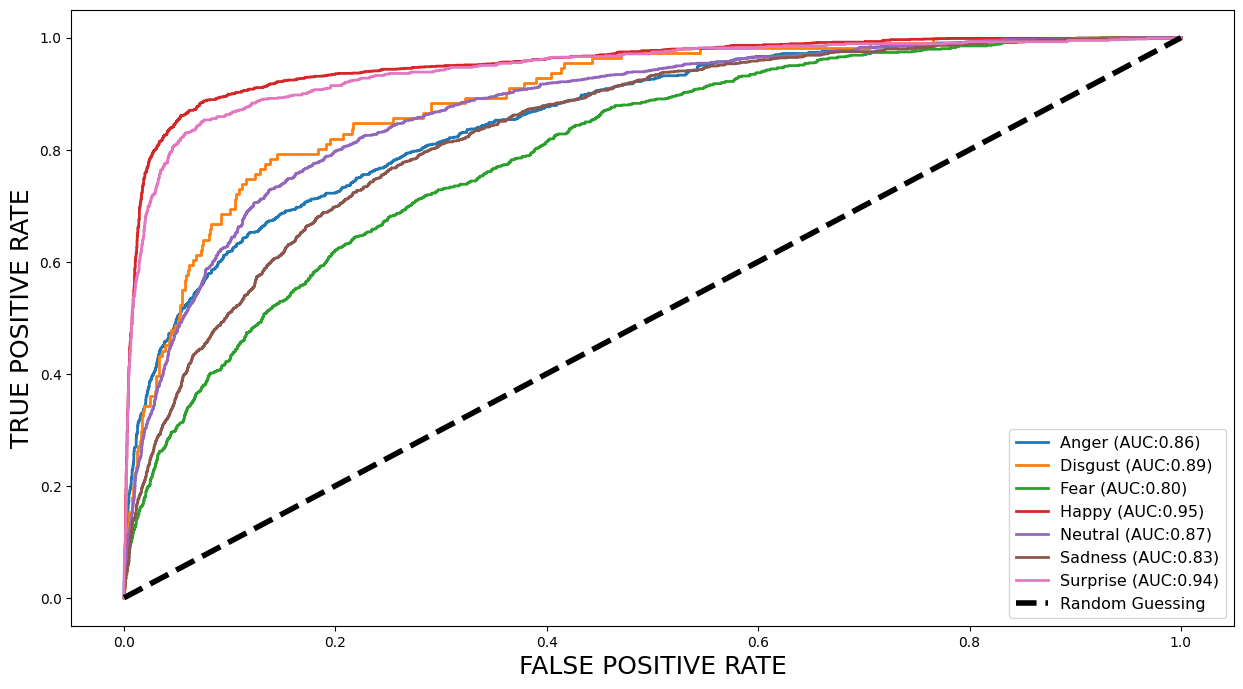

In [28]:
fig, c_ax = plt.subplots(1,1, figsize = (15,8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test , predictions , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=18)
plt.legend(fontsize = 11.5)
plt.show()

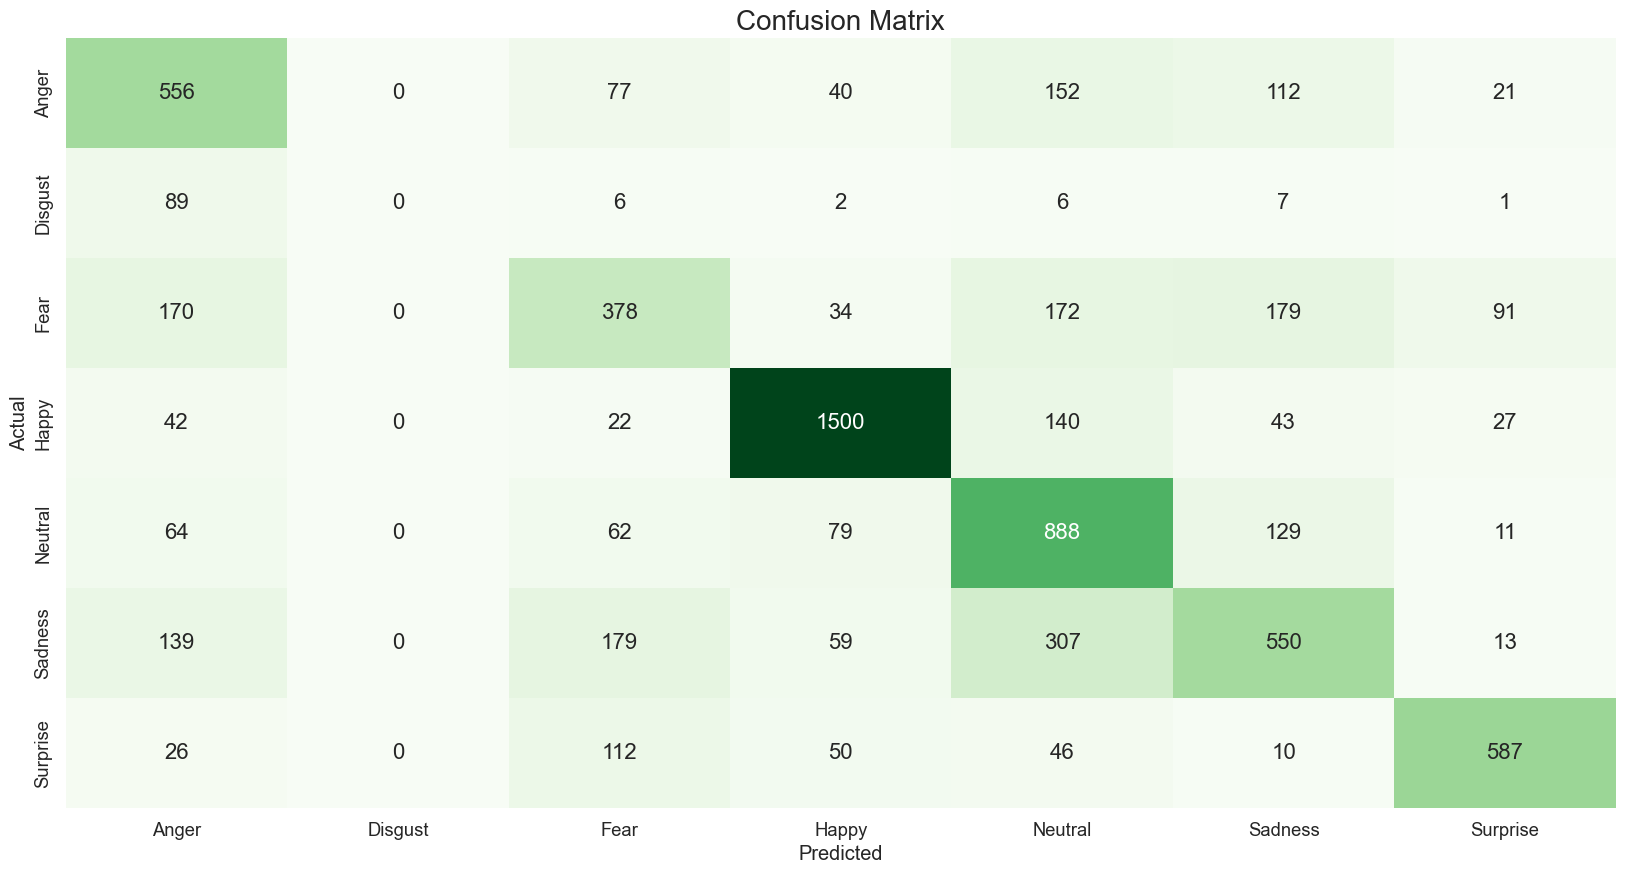

In [31]:
cm_data = confusion_matrix(y_test , y_preds)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Greens", annot=True, annot_kws={"size": 16}, fmt='g')

In [1]:
import cv2

In [11]:
from keras.models import load_model
import numpy as np
# Load your trained model
opsmodel = load_model('emotion_detection_model2.keras')

In [32]:
def predict_emotion(img_path,model):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (48, 48))  
    img = np.reshape(img, [1, 48, 48, 3])  
    prediction_proba = model.predict(img)
    indices = np.argmax(prediction_proba, axis=1)
    predicted_classes = [CLASS_LABELS[i] for i in indices]
    return predicted_classes


In [33]:
print(CLASS_LABELS)

['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', 'Surprise']


In [37]:
print(predict_emotion(r'test/happy/im4.png',opsmodel))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
['Happy']


In [40]:
print(predict_emotion(r'test\disgusted\im44.png',opsmodel))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
['Happy']
